how are facebook + advertisers treating these advertisers differently?
is there a difference in:
- interest vs. non-interest targeting b/w users
- custom audience targeting between users

steps:
* pull out full_json by ad id from DB, match ad ids against user_ads; DONE
* preprocess the full_json for each task and aggregate info by user; DONE
* visualize the fraction of just age-gender vs. interest vs. custom for each user (multi-bar chart maybe); DONE

In [167]:
import csv, json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats
plt.rcParams['font.family'] = 'Helvetica'
import matplotlib.lines as mlines
from math import sqrt
import numpy as np

In [36]:
# load targetings
ad_targetings = {}
with open('../db-processing/ad-targetings.tsv', 'r') as fh:
    for line in fh:
        ad_id, targeting = line.split('\t')
        targeting = json.loads(targeting.strip())
        ad_targetings[ad_id] = targeting
        
# load user ads
# read ads for each user
user_ads_file = '../db-processing/user_ads_timestamps.tsv'
user_ads = {}
with open(user_ads_file, 'r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    for line in reader:
        uid = line[0]
        # load the IDs, leaving out timestamps       
        ids = [x.split(',')[0] for x in line[1:]]        
        if len(ids):
            user_ads[uid] = ids
            
user_labels = {
    '609471590c51b81087087049': 'A',
    '5e3cc28a194a520c0c128f13': 'B',
    '5df3ab425777b528cb364cde': 'C',
    '5d1ea7e579b687001af802c6': 'D',
    '5c6ac9e5d9c5be000174497f': 'E',
    '5bba226d70f8df0001c065f3': 'F'
}

inf_dem = {
    '609471590c51b81087087049': {'age': (26, 29), 'gender':  ['MALE', 'ANY']},
    '5c6ac9e5d9c5be000174497f': {'age':  (25, 28), 'gender':  ['FEMALE', 'ANY']},
    '5df3ab425777b528cb364cde': {'age':  (36, 39), 'gender': ['FEMALE', 'ANY']},   
    '5d1ea7e579b687001af802c6': {'age':  (51, 54), 'gender':  ['FEMALE', 'ANY']},
    '5e3cc28a194a520c0c128f13': {'age':  (42, 55), 'gender':  ['ANY']},
    '5bba226d70f8df0001c065f3': {'age': (26, 29), 'gender':  ['FEMALE', 'ANY']},
    '5e1b299528c70235eeed62ef': {'age':  (18, 65), 'gender':  ['ANY']}    
}

In [67]:
ca_advertisers = {}
# 'ca_owner_name': 'Klarna'

def get_targeting(ut, aid):
    # also updates global list of CA advertisers
    global ca_advertisers
    
    # there is always an el['__typename'] == 'WAISTUIAgeGenderType'
    all_targetings = {'id': aid}
    for el in ut['data']['waist_targeting_data']:
        if el['__typename'] == 'WAISTUIInterestsType':
            all_targetings['interests'] = set([i['name'] for i in el['interests']])
        elif el['__typename'] == 'WAISTUICustomAudienceType':
            ca_advertisers[aid] = el['dfca_data']['ca_owner_name']
            all_targetings['custom'] = True
        elif el['__typename'] == 'WAISTUILocationType':
            gran = json.loads(el['serialized_data'])['location_granularity']
            loc = el['location_name']
            all_targetings['location'] = {'loc': loc, 'gran': gran}
        elif el['__typename'] == 'WAISTUIAgeGenderType':
            all_targetings['age-gender'] = {
                'age_min': el['age_min'],
                'age_max': el['age_max'],
                'gender': el['gender']
            }        
        
    return all_targetings

In [68]:
# pull out all targeting interests seen in the data
user_interests = defaultdict(list)
user_targetings = defaultdict(list)
for uid in user_ads:
    for aid in user_ads[uid]:
        tar = get_targeting(ad_targetings[aid], aid)
        user_targetings[uid].append(tar)
        if 'interests' in tar:
            user_interests[uid].extend(list(tar['interests']))

In [50]:
# helpers to pull out info from targeting dict
tar_interest = lambda uid: sum([1 for t in user_targetings[uid] if 'interests'in t])
tar_custom = lambda uid: sum([1 for t in user_targetings[uid] if 'custom' in t])

In [69]:
for uid in user_interests:
    freqs = Counter(user_interests[uid])
    total = len(user_ads[uid])
    label = user_labels[uid] if uid in user_labels else None
    print('--', uid, f'({label}) --')
    print(f'[inferred demographics: {inf_dem[uid]}]')
    print(f'Total: {total}')
#     custom = sum([1 for t in user_targetings[uid] if 'custom' in t])
    custom = tar_custom(uid)
    print(f'custom: {custom} ({round(custom/total * 100, 2)}%)\
        {[ca_advertisers[aid] for aid in user_ads[uid] if aid in ca_advertisers]}')
    interest_targeted = tar_interest(uid)
    generic = total - custom - interest_targeted
    print(f'interest: {interest_targeted} ({round(interest_targeted/total * 100, 2)}%)')
    print(f'generic: {generic} ({round(generic/total * 100, 2)}%)\n')

-- 5c6ac9e5d9c5be000174497f (E) --
[inferred demographics: {'age': (25, 28), 'gender': ['FEMALE', 'ANY']}]
Total: 39
custom: 14 (35.9%)        ['Panera Bread', 'Chime', 'Chime', 'Chumba Casino', 'WORTHY', 'Klarna', 'Meow Wolf', 'Peacock TV', 'Creatd', 'Adobe', 'Chime', 'Zumbini', 'Sports Research', 'SUPER Weekend']
interest: 8 (20.51%)
generic: 17 (43.59%)

-- 609471590c51b81087087049 (A) --
[inferred demographics: {'age': (26, 29), 'gender': ['MALE', 'ANY']}]
Total: 186
custom: 31 (16.67%)        ['HBO Max', 'StackSocial', 'We Play', 'Supply', 'Quiet Punch', 'Patrick Adair Designs', 'LY SHOP', 'Disney Streaming Services', 'StackSocial', 'Walmart.com', 'Woz U', 'Quiet Punch', 'HBO Max', 'HBO Max', 'Honey', 'Quiet Punch', 'WWE', 'Microsoft Paid Social', 'Vital Digital Group', 'WWE', 'HBO Max', 'WWE', 'Freshly', 'Regal', 'Firestone Complete Auto Care', 'HBO Max', 'HBO Max', 'With Cove', 'HBO Max', 'Freshly', 'AAF Nation LLC']
interest: 63 (33.87%)
generic: 92 (49.46%)

-- 5bba226d70f8df0

In [49]:
def normal_bin_conf(p, n, alpha=.95):
    tab = {0.90: 1.645, 0.95: 1.96, 0.99: 2.58}
    z = tab[alpha]
    # binomial proportion confidence interval
    return z * sqrt((p * (1-p))/n)

In [94]:
regions = ['country', 'region', 'city']  # increasing specificity
def targeting_specificity(uid, exclude_nongeneric=True):
    # return 2 lists: location specificity, age range width
    loc_gran = []
    age_range = []
    for tar in user_targetings[uid]:
        if exclude_nongeneric and ('custom' in tar or 'interests' in tar):
            # enable when don't want to plot specific targeting options
            continue
        if 'location' not in tar or 'age-gender' not in tar:
            continue
        else:
            loc_gran.append(regions.index(tar['location']['gran']))
            age_range.append(tar['age-gender']['age_max'] - tar['age-gender']['age_min'])
            
    return loc_gran, age_range

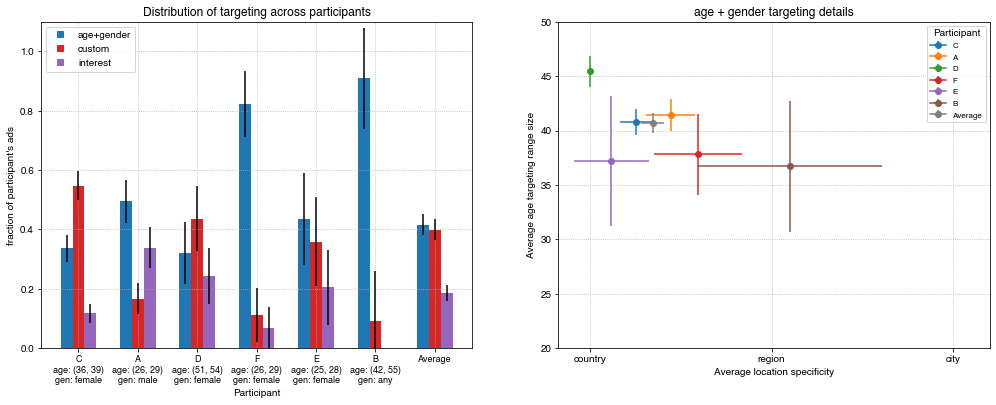

In [129]:
# question:
# are the older users (according to Piotr's data more often in custom audiences)
# answer: plot bar chart of above, with demographics in legend

# question 2: of the generically targeted ads, what's the location and gender granularity?
# answer: second plot w/ loc granularity on x axis and age range size on y-axis -- color etc for other things

f, axs = plt.subplots(1, 2, figsize=(17, 6))

# only plotting the 6 users who gave multiple ads
offs = np.array([-0.2, 0, 0.2])
user_order = sorted(user_ads.keys(), key=lambda pid: len(user_ads[pid]), reverse=True)
user_order = user_order[:-1]

# stuff for computing average of entire data
loc_gran_all, age_ranges_all = [], []
custom_total, generic_total, interest_total = 0, 0, 0

confidence = .90  # for mean error in targeting specificity
for i, uid in enumerate(user_order):
    total = len(user_ads[uid])
    
    interest_targeted = tar_interest(uid)
    custom = tar_custom(uid)
    generic = total - interest_targeted - custom
    interest_total += interest_targeted; custom_total += custom; generic_total += generic
    # convert to fractions
    interest_targeted /= total; custom /= total; generic /= total    
    
    bars = [generic, custom, interest_targeted]
    errs = [normal_bin_conf(k, total) for k in bars]
    axs[0].bar(offs + i, bars, width=.2,
           color=['tab:blue', 'tab:red', 'tab:purple'], yerr=errs)
    
    # plot 2: go over user_targetings 
    loc_gran, age_range = targeting_specificity(uid, exclude_nongeneric=True)
    loc_gran_all.extend(loc_gran); age_ranges_all.extend(age_range)
    mean_loc_gran, mean_age_range = np.mean(loc_gran), np.mean(age_range)
    
    loc_se = scipy.stats.sem(loc_gran)
    loc_err = loc_se * scipy.stats.t.ppf((1 + confidence) / 2., len(loc_gran)-1)
    age_se = scipy.stats.sem(age_range)
    age_err = age_se * scipy.stats.t.ppf((1 + confidence) / 2., len(age_range)-1)

    axs[1].errorbar(mean_loc_gran, mean_age_range, label=user_labels[uid], marker='o',
                    xerr=loc_err, yerr=age_err)
    
# also show total averages in bar plot
total = interest_total + custom_total + generic_total
interest_total /= total; custom_total /= total; generic_total /= total    
bars = [generic_total, custom_total, interest_total]
errs = [normal_bin_conf(k, total) for k in bars]
axs[0].bar(offs + len(user_order), bars, width=.2,
       color=['tab:blue', 'tab:red', 'tab:purple'], yerr=errs)

# ... and in scatterplot
mean_loc_gran, mean_age_range = np.mean(loc_gran_all), np.mean(age_ranges_all)    
loc_se = scipy.stats.sem(loc_gran_all)
loc_err = loc_se * scipy.stats.t.ppf((1 + confidence) / 2., len(loc_gran_all)-1)
age_se = scipy.stats.sem(age_ranges_all)
age_err = age_se * scipy.stats.t.ppf((1 + confidence) / 2., len(age_ranges_all)-1)

axs[1].errorbar(mean_loc_gran, mean_age_range, label='Average', marker='o', color='gray',
                xerr=loc_err, yerr=age_err)

# custom legend
generic = mlines.Line2D([], [], color='tab:blue', marker='s', ls='', label='age+gender')
custom = mlines.Line2D([], [], color='tab:red', marker='s', ls='', label='custom')
interest_targeted = mlines.Line2D([], [], color='tab:purple', marker='s', ls='', label='interest')
axs[0].legend(handles=[generic, custom, interest_targeted], loc='upper left')

axs[0].set_ylim(bottom=0, top=1.1)
axs[0].set_xticks(np.arange(len(user_order)+1))
labels = [user_labels[u]+'\n'\
          +'age: '+str(inf_dem[u]['age'])+'\n'
          +'gen: '+str(inf_dem[u]['gender'][0].lower()) for u in user_order]
labels.append('Average')
axs[0].set_xticklabels(labels, fontsize=9)
axs[0].set_xlabel('Participant')
axs[0].grid(ls=':')
axs[0].set_title('Distribution of targeting across participants')
axs[0].set_ylabel("fraction of participant's ads")

axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(regions)
axs[1].set_xlabel('Average location specificity')
axs[1].set_ylabel('Average age targeting range size')
axs[1].legend(title="Participant", fontsize=8)
axs[1].grid(ls=':')
axs[1].set_ylim(top=50, bottom=20)
axs[1].set_xlim(right=2.2)
axs[1].set_title('age + gender targeting details')

plt.savefig('participant-targeting-distribution.jpg', dpi=200, bbox_inches='tight')

**Results:**
- Noticeable differences in each person's distribution it seems (C has lots of CA targeting, A is mostly generic etc.)
- a larger share of age+gender (e.g. F and B) means FB is more responsible for this person's ads
- looking at the targeting of age+gender only (right plot): there seems to be a skew towards larger ranges and less specific locations -- suggesting that people are handing over mostly to Facebook in these cases

Generally, an important result. Facebook's algorithm isn't always the most important factor in delivery, but when advertisers choose to give up control, a lot of it is left up to Facebook.
If it is so in the most problematic cases, that's a key result.

In [ ]:
# question: 
# what fractions of ads coded with "suspicious" and "revisit" are targeted generically?
# maybe we can assign each participant a harm score

In [9]:
# load the suspicious file
# read pilot ads coding
coding_file = '../pilot-ads-coding/angelica-coding.jsonl'
coding = {}
ad_body = {}
with open(coding_file, 'r') as fh:
    for line in fh:
        obj = json.loads(line)
        coding[obj['Ad ID']] = obj['label']
        ad_body[obj['Ad ID']] = {
            'advertiser': obj['advertiser'],
            'message': obj['data']
        }
        
susp_ads = list(coding.keys())

In [30]:
# ads coded with the "suspicious" code
for aid in coding:
    if "Suspicious" in coding[aid]:
        tar = get_targeting(ad_targetings[aid], aid)
        message = ad_body[aid]['message'][16:100]
        advertiser = ad_body[aid]['advertiser']
        print(f'{tar.keys()}; {advertiser}; {aid}\n')

dict_keys(['age-gender', 'location']); Noom; 23847898979880449

dict_keys(['age-gender', 'location']); Freshly; 6244015979542

dict_keys(['interests', 'age-gender', 'location']); Tracy Anderson Method; 6251953218564

dict_keys(['interests', 'age-gender', 'location']); Health Insider; 23848886915850491

dict_keys(['age-gender', 'location']); Steel Supplements; 23847413596840184

dict_keys(['age-gender', 'location']); Tracy Anderson Method; 6248004708564

dict_keys(['age-gender', 'location']); Schizophrenia CCT Study; 23848259466120743

dict_keys(['age-gender', 'location']); Tonal; 23847978285850782

dict_keys(['age-gender', 'location']); Everlywell; 23848087016290391

dict_keys(['age-gender', 'location']); Tracy Anderson Method; 6248004641164

dict_keys(['age-gender', 'location']); White Claw Hard Seltzer; 23848045944090703

dict_keys(['custom', 'age-gender', 'location']); Tracy Anderson Method; 6250555962964

dict_keys(['age-gender', 'location']); Nurx; 23847521608600572

dict_keys(['a

In [136]:
# ads that i personally detest. these are ads where i'm willing to bet they're scams
# Erie Metal Roof (x3), Savvy Homeowner, Become a Game Designer (x3), Sunrise Solar, Luckyland Slots, Life Inspiration
# LMB, LetsGetChecked (x4)

# The Penny Hoarder
# Lower My Bills
# LetsGetChecked; LetsGetChecked; LetsGetChecked; LetsGetChecked
# mConsent
# Minting Nickels
# Quicken Loans

hate = ['6265572946641', '6269895191441', '6269895209841', '23847549917010410',
        '23845251205600750', '23847571411330750', '23847689537720750', '23848273117330459',
       '23847586780210100', '23847949836880528', '6267697243641', '23848338693850343', '23848232246370343',
       '23848232246690343', '23848232246790343', '6242292113312', '23847984315350591', '23848191626470579']

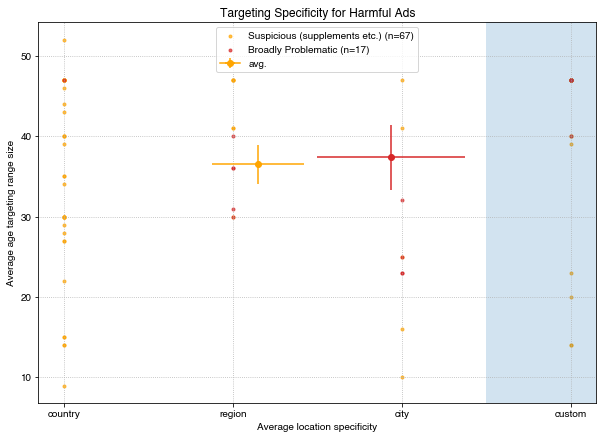

In [180]:
f, ax = plt.subplots(figsize=(10, 7))

def get_targeting_loc(aid):
    tar = get_targeting(ad_targetings[aid], aid)
    if 'custom' in tar:
        return len(regions)
    if 'location' in tar:
        return regions.index(tar['location']['gran'])
    
def get_targeting_age(aid):
    tar = get_targeting(ad_targetings[aid], aid)
    if 'age-gender' in tar:
        return tar['age-gender']['age_max'] - tar['age-gender']['age_min']

# plot ads with suspicious code in one place
loc_gran_arr, age_range_arr = [], []
processed = set()
for aid in coding:
    if "Suspicious" in coding[aid]:
        processed.add(aid)
        loc_gran, age_range = get_targeting_loc(aid), get_targeting_age(aid)
        if loc_gran is not None and age_range is not None:
            loc_gran_arr.append(loc_gran)
            age_range_arr.append(age_range)            

loc_se = scipy.stats.sem(loc_gran_arr)
loc_err = loc_se * scipy.stats.t.ppf((1 + confidence) / 2., len(loc_gran_arr)-1)
age_se = scipy.stats.sem(age_range_arr)
age_err = age_se * scipy.stats.t.ppf((1 + confidence) / 2., len(age_range_arr)-1)

# plot both the individual points and the average
plt.scatter(loc_gran_arr, age_range_arr, color='orange', alpha=.7, marker='.',
            label=f'Suspicious (supplements etc.) (n={len(loc_gran_arr)})')
plt.errorbar(np.mean(loc_gran_arr), np.mean(age_range_arr), marker='o',
    xerr=loc_err, yerr=age_err, color='orange', label='avg.')

# plot cherry-picked ads that fulfill my definition of harm
loc_gran_arr, age_range_arr = [], []
for aid in hate:
    # don't re-plot ads that Angelica already marked as suspicious
    if aid in processed:
        continue
    loc_gran, age_range = get_targeting_loc(aid), get_targeting_age(aid)
    if loc_gran is not None and age_range is not None:
        loc_gran_arr.append(loc_gran)
        age_range_arr.append(age_range)

loc_se = scipy.stats.sem(loc_gran_arr)
loc_err = loc_se * scipy.stats.t.ppf((1 + confidence) / 2., len(loc_gran_arr)-1)
age_se = scipy.stats.sem(age_range_arr)
age_err = age_se * scipy.stats.t.ppf((1 + confidence) / 2., len(age_range_arr)-1)

plt.scatter(loc_gran_arr, age_range_arr, color='tab:red', alpha=.7, marker='.',
            label=f'Broadly Problematic (n={len(hate)})')
plt.errorbar(np.mean(loc_gran_arr), np.mean(age_range_arr), marker='o',
    xerr=loc_err, yerr=age_err, color='tab:red')

ax.legend()
ax.grid(ls=':')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(regions + ['custom'])
rect = patches.Rectangle((2.5,1), 2, 60, linewidth=0, facecolor='tab:blue', alpha=0.2)
ax.add_patch(rect)
ax.set_xlabel('Average location specificity')
ax.set_ylabel('Average age targeting range size')
ax.legend()
ax.set_title('Targeting Specificity for Harmful Ads')

plt.savefig('harmful-ads-targ-spec.jpg', dpi=200, bbox_inches='tight')